In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import urllib.request
import geopandas as gpd
from geopandas.tools import geocode
import seaborn as sns
import statsmodels.formula.api as smf

from scipy.stats import t
from sklearn.metrics import r2_score

from geopy.geocoders import GoogleV3
import geopy.distance
import googlemaps



In [2]:
#read in NYSED test scores, defining the sheets in the workbook and concatenating for all student types

sheets = ['All', 'SWD', 'Ethnicity', 'Gender', 'Econ Status', 'ELL']

ela = pd.concat([pd.read_excel('https://infohub.nyced.org/docs/default-source/default-document-library/school-ela-results-2013-2022-(public).xlsx',
                              sheet_name = sheet) for sheet in sheets], ignore_index= True)
math = pd.concat([pd.read_excel('https://infohub.nyced.org/docs/default-source/default-document-library/school-math-results-2013-2022-(public).xlsx',
                              sheet_name = sheet) for sheet in sheets], ignore_index= True)


In [3]:
print(ela.shape, math.shape)

(486678, 18) (481845, 18)


In [4]:
ela.head()

,Unnamed: 0,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,01M01532013All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2013,All Students,27,289.296295,14,51.851852,11,40.740742,2,7.407407,0,0,2,7.407407
1,01M01532014All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2014,All Students,18,285.111114,10,55.555557,8,44.444443,0,0,0,0,0,0
2,01M01532015All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2015,All Students,16,281.8125,9,56.25,5,31.25,2,12.5,0,0,2,12.5
3,01M01532016All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2016,All Students,20,292.5,10,50,6,30,4,20,0,0,4,20
4,01M01532017All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2017,All Students,27,302.370361,10,37.037037,8,29.629629,7,25.925926,2,7.407407,9,33.333332


In [5]:
math.head()

,Unnamed: 0,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,01M01532013All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2013,All Students,27,277.777771,16,59.259258,11,40.740742,0,0,0,0,0,0
1,01M01532014All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2014,All Students,18,286.388886,6,33.333332,9,50,2,11.111111,1,5.555555,3,16.666666
2,01M01532015All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2015,All Students,17,279.588226,10,58.823528,4,23.529411,2,11.764706,1,5.882353,3,17.647058
3,01M01532016All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2016,All Students,21,274.809509,13,61.904762,4,19.047619,4,19.047619,0,0,4,19.047619
4,01M01532017All Students,01M015,P.S. 015 ROBERTO CLEMENTE,3,2017,All Students,29,301.551727,8,27.586206,9,31.034483,7,24.137932,5,17.241379,12,41.379311


In [6]:
#School Addresses
#file can be found here: 'https://www.nycenet.edu/PublicApps/LCGMS.aspx'

school_location = pd.read_excel('C:\\Users\\aspadaro\\Desktop\\UDS\\LCGMS_School Data.xlsx')
school_location.columns

Index(['ATS System Code', 'Location Code', 'Location Name', 'BEDS Number',
       'Managed By Name', 'Location Type Description',
       'Location Category Description', 'Grades', 'Grades Final', 'Open Date',
       'Status Description', 'Building Code', 'Primary Address', 'City',
       'State Code', 'Zip', 'Borough Block Lot', 'Census Tract',
       'Community District', 'Council District', 'NTA', 'NTA_Name',
       'Principal Name', 'Principal Title', 'Principal Phone Number',
       'Fax Number', 'Geographical District Code',
       'Administrative District Code', 'Administrative District Location Code',
       'Administrative District Name', 'Community School Sup Name',
       'HighSchool Network Location Code', 'HighSchool Network Name',
       'BCO Location Code', 'BCO Location Name', 'BCO Executive Director',
       'BCO Executive Director Title'],
      dtype='object')

In [7]:
#keep only the relevant address columns

school_location = school_location[['ATS System Code','Primary Address', 'City','State Code', 'Zip']]
school_location.head()

,ATS System Code,Primary Address,City,State Code,Zip
0,NaN,West Prospect Avenue,Mount Vernon,NY,10550
1,01M015,333 EAST 4 STREET,MANHATTAN,NY,10009
2,01M020,166 ESSEX STREET,MANHATTAN,NY,10002
3,01M034,730 East 12 Street,Manhattan,NY,10009
4,01M063,121 EAST 3 STREET,MANHATTAN,NY,10009


In [8]:
school_location['full_address'] = school_location['Primary Address'] +', ' +school_location['City'] +', '+ school_location['State Code'] +', '+ school_location['Zip'].astype(str)
school_location


,ATS System Code,Primary Address,City,State Code,Zip,full_address
0,NaN,West Prospect Avenue,Mount Vernon,NY,10550,"West Prospect Avenue, Mount Vernon, NY, 10550"
1,01M015,333 EAST 4 STREET,MANHATTAN,NY,10009,"333 EAST 4 STREET, MANHATTAN, NY, 10009"
2,01M020,166 ESSEX STREET,MANHATTAN,NY,10002,"166 ESSEX STREET, MANHATTAN, NY, 10002"
3,01M034,730 East 12 Street,Manhattan,NY,10009,"730 East 12 Street, Manhattan, NY, 10009"
4,01M063,121 EAST 3 STREET,MANHATTAN,NY,10009,"121 EAST 3 STREET, MANHATTAN, NY, 10009"
...,...,...,...,...,...,...
1881,84X705,14 WEST 170 STREET,BRONX,NY,10452,"14 WEST 170 STREET, BRONX, NY, 10452"
1882,84X706,3565 THIRD AVENUE,BRONX,NY,10456,"3565 THIRD AVENUE, BRONX, NY, 10456"
1883,84X717,1506-30 Brook Avenue,Bronx,NY,10457,"1506-30 Brook Avenue, Bronx, NY, 10457"
1884,84X718,3740 BAYCHESTER AVENUE,BRONX,NY,10466,"3740 BAYCHESTER AVENUE, BRONX, NY, 10466"


In [9]:
API = ''
geolocator = GoogleV3(api_key=API)


In [10]:
school_location['longitude']  = ''
school_location['latitude'] = ''
pd.set_option('mode.chained_assignment', None)

for i in range(len(school_location)):
    location = geolocator.geocode(school_location.full_address[i])
    school_location.longitude[i] = location.longitude
    school_location.latitude[i]= location.latitude


In [11]:
school_location = gpd.GeoDataFrame(school_location, crs="EPSG:4326", geometry=gpd.points_from_xy(school_location.longitude, school_location.latitude))


In [12]:
## Boundaries of School Districts
#Shapefile found here: 'https://data.cityofnewyork.us/api/geospatial/r8nu-ymqj?method=export&format=Shapefile'

districts = gpd.read_file('C:\\Users\\aspadaro\\Documents\\UDS\\School Districts\\geo_export_f693079f-93e2-405c-b3cf-2a6bfe9ba25f.shp')
districts.head()

,school_dis,shape_area,shape_leng,geometry
0,32.0,5.189850e+07,37251.057496,"POLYGON ((-73.91181 40.70343, -73.91290 40.702..."
1,16.0,4.676362e+07,35848.904343,"POLYGON ((-73.93312 40.69579, -73.93237 40.695..."
2,17.0,1.284405e+08,68356.103241,"POLYGON ((-73.92044 40.66563, -73.92061 40.665..."
3,31.0,1.604167e+09,430023.147272,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
4,4.0,5.262057e+07,52062.883377,"MULTIPOLYGON (((-73.92134 40.80085, -73.92114 ..."


<AxesSubplot:>

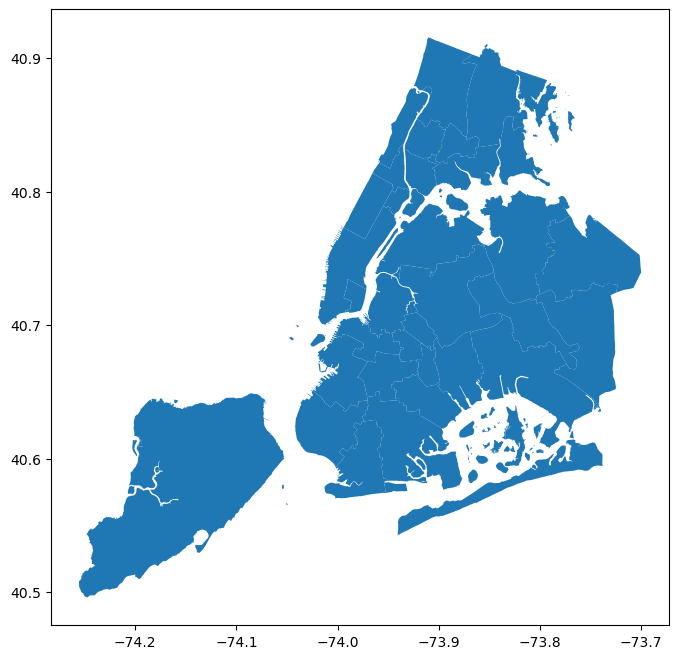

In [13]:
districts.plot(figsize=(8,8))

In [14]:
#Demographics by school - including poverty for school
#found on open data here: 'https://data.cityofnewyork.us/Education/2017-18-2021-22-Demographic-Snapshot/c7ru-d68s'

demo = pd.read_excel('https://data.cityofnewyork.us/api/views/c7ru-d68s/files/7619cd06-7db2-4c98-9d9e-abfe186c169d?download=true&filename=Demographic%20Snapshot%202017-18%20to%202021-22%20(Public).xlsx')

#Keep only relevant years 2019 and 2022
demo = demo[(demo['Year'] == '2018-19') | (demo['Year'] == '2021-22')]
demo.head()

,DBN,School Name,Year,Total Enrollment,Grade 3K,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,...,% White,# Missing Race/Ethnicity Data,% Missing Race/Ethnicity Data,# Students with Disabilities,% Students with Disabilities,# English Language Learners,% English Language Learners,# Poverty,% Poverty,Economic Need Index
1,01M015,P.S. 015 Roberto Clemente,2018-19,174,0,13,20,33,30,30,...,0.034483,0,0.000000,39,0.224138,8,0.045977,147,0.844828,0.887925
4,01M015,P.S. 015 Roberto Clemente,2021-22,179,0,15,30,26,24,22,...,0.067039,0,0.000000,38,0.212290,11,0.061453,150,0.837989,0.879354
6,01M019,P.S. 019 Asher Levy,2018-19,249,0,10,30,39,43,41,...,0.072289,0,0.000000,102,0.409639,8,0.032129,183,0.73494,0.686858
9,01M019,P.S. 019 Asher Levy,2021-22,176,9,7,22,20,22,23,...,0.119318,3,0.017045,72,0.409091,6,0.034091,124,0.704545,0.678349
11,01M020,P.S. 020 Anna Silver,2018-19,481,0,42,61,69,76,67,...,0.045738,1,0.002079,117,0.243243,63,0.130977,326,0.677755,0.754006


In [15]:
#data above 95% eni converted to 96% to allow for yoy

demo = demo.replace({'Economic Need Index': {'Above 95%': 0.96,}})
demo.describe()

,Total Enrollment,Grade 3K,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,...,% Native American,# White,% White,# Missing Race/Ethnicity Data,% Missing Race/Ethnicity Data,# Students with Disabilities,% Students with Disabilities,# English Language Learners,% English Language Learners,Economic Need Index
count,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,...,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000,3711.000000
mean,561.272433,3.073835,15.977904,39.682296,41.026947,40.973861,41.217192,41.785503,41.704123,41.607653,...,0.011861,81.049852,0.117399,2.634869,0.003855,118.856373,0.235932,79.354621,0.143375,0.747339
std,462.071855,15.687942,41.855309,46.221144,47.913498,48.001972,49.191230,51.087028,51.290655,84.721591,...,0.020784,170.652880,0.170534,9.127640,0.009325,97.426916,0.158441,103.133025,0.143852,0.195415
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067029
25%,308.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003236,6.000000,0.015244,0.000000,0.000000,64.000000,0.162296,19.000000,0.048895,0.663291
50%,453.000000,0.000000,0.000000,27.000000,29.000000,29.000000,27.000000,25.000000,24.000000,0.000000,...,0.006849,15.000000,0.034783,0.000000,0.000000,94.000000,0.207612,44.000000,0.102713,0.807888
75%,657.500000,0.000000,29.000000,70.000000,72.000000,73.000000,73.000000,74.000000,75.000000,62.000000,...,0.013180,74.500000,0.138220,2.000000,0.003333,140.000000,0.258290,100.000000,0.191070,0.892647
max,5958.000000,523.000000,1219.000000,319.000000,322.000000,299.000000,345.000000,335.000000,324.000000,716.000000,...,0.416107,2924.000000,0.956790,202.000000,0.116090,853.000000,1.000000,1069.000000,1.000000,0.960000


In [16]:
yoy_eni= demo.pivot(index=['DBN'], columns=['Year'], values=['Total Enrollment','Economic Need Index'])
yoy_eni[('Economic Need Index', 'yoy')] = yoy_eni[('Economic Need Index', '2021-22')]-yoy_eni[('Economic Need Index', '2018-19')]
yoy_eni

Total Enrollment         Economic Need Index                    
Year            2018-19 2021-22             2018-19   2021-22       yoy
DBN                                                                    
01M015            174.0   179.0            0.887925  0.879354 -0.008571
01M019            249.0   176.0            0.686858  0.678349 -0.008510
01M020            481.0   351.0            0.754006  0.753182 -0.000824
01M034            305.0   258.0            0.948446  0.944488 -0.003958
01M063            230.0   186.0            0.737144  0.703831 -0.033313
...                 ...     ...                 ...       ...       ...
84X705            272.0   392.0            0.883607  0.916872  0.033266
84X706            681.0   587.0            0.879620  0.895044  0.015424
84X717            331.0   314.0            0.787385  0.847570  0.060185
84X718            564.0   572.0            0.612364  0.631252  0.018887
84X730            430.0   598.0            0.887860  0.902684  0.014823

[1882 rows x 5 columns]

<AxesSubplot:ylabel="('Economic Need Index', 'yoy')">

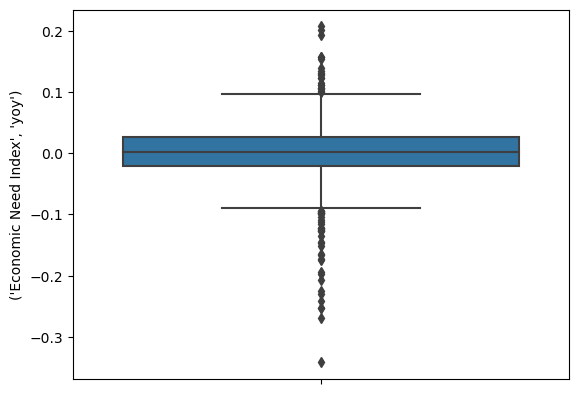

In [17]:
sns.boxplot(y=('Economic Need Index',     'yoy'),data =yoy_eni)

In [18]:
#add test type to combine dataframes

ela['test'] = 'ELA'
math['test'] = 'Math'

#check if headers are equal before merge

ela[0:0].equals(math[0:0])

True

In [19]:
#combine files, add in district, drop missing/supressed data indicated by "s"

ela_math = pd.concat([ela, math], ignore_index=True)
ela_math['school_dis'] = pd.to_numeric(ela_math['DBN'].str[0:2])
ela_math = ela_math[ela_math['Mean Scale Score'] != 's']
ela_math = ela_math.infer_objects()


In [20]:
#consider results before and after the pandemic
ela_math =ela_math[ela_math['Year']>=2019]

In [21]:
#add comparison of the % Level 3+4 grades which is equivalent to being on grade level
ela_math = ela_math.sort_values(by=['DBN', 'School Name', 'Grade', 'Year', 'Category', 'test'])

YoY = ela_math.pivot(index=['DBN', 'School Name', 'Grade', 'Category'], columns=['Year','test'], values=['Number Tested','% Level 3+4','# Level 3+4'])
YoY.columns = YoY.columns.to_flat_index()
YoY = YoY.reset_index()
YoY.columns

YoY = YoY.rename(columns={('Number Tested', 2019, 'ELA'):'Ntested_19_ela', 
                          ('Number Tested', 2019, 'Math'):'Ntested_19_math',
                          ('Number Tested', 2022, 'ELA'):'Ntested_22_ela',
                          ('Number Tested', 2022, 'Math'):'Ntested_22_math',
                          ('% Level 3+4', 2019, 'ELA'):'prof_19_ela',
                          ('% Level 3+4', 2019, 'Math'):'prof_19_math',
                          ('% Level 3+4', 2022, 'ELA'):'prof_22_ela',
                          ('% Level 3+4', 2022, 'Math'):'prof_22_math',
                          ('# Level 3+4', 2019, 'ELA'):'Nprof_19_ela',
                          ('# Level 3+4', 2019, 'Math'):'Nprof_19_math',
                          ('# Level 3+4', 2022, 'ELA'):'Nprof_22_ela',
                          ('# Level 3+4', 2022, 'Math'):'Nprof_22_math'})

In [22]:
#create a subgroup dictionary
subgroup_dict = {
    'All Students' : 'all',
    'Not SWD' : 'swd',
    'SWD' : 'swd',
    'Asian' : 'race',
    'Black' : 'race', 
    'Hispanic' : 'race',
    'White' : 'race',
    'Female' : 'gender',
    'Male' : 'gender',
    'Econ Disadv' : 'econ_status',
    'Not Econ Disadv' : 'econ_status',
    'Current ELL' : 'ell', 
    'Ever ELL' : 'ell',
    'Never ELL' : 'ell'}

#create subgroup column using the new dictionary
YoY['subgroup_type'] = YoY['Category'].map(subgroup_dict)

In [23]:
YoY.columns

Index(['DBN', 'School Name', 'Grade', 'Category', 'Ntested_19_ela',
       'Ntested_19_math', 'Ntested_22_ela', 'Ntested_22_math', 'prof_19_ela',
       'prof_19_math', 'prof_22_ela', 'prof_22_math', 'Nprof_19_ela',
       'Nprof_19_math', 'Nprof_22_ela', 'Nprof_22_math', 'subgroup_type'],
      dtype='object')

In [24]:
YoY['prof_yoy_ela'] = YoY['prof_22_ela']-YoY['prof_19_ela']
YoY['prof_yoy_math'] = YoY['prof_22_math']-YoY['prof_19_math']
YoY

,DBN,School Name,Grade,Category,Ntested_19_ela,Ntested_19_math,Ntested_22_ela,Ntested_22_math,prof_19_ela,prof_19_math,prof_22_ela,prof_22_math,Nprof_19_ela,Nprof_19_math,Nprof_22_ela,Nprof_22_math,subgroup_type,prof_yoy_ela,prof_yoy_math
0,01M015,P.S. 015 ROBERTO CLEMENTE,3,All Students,27.0,26.0,21.0,21.0,70.370369,69.230766,23.809525,23.809525,19.0,18.0,5.0,5.0,all,-46.560844,-45.421242
1,01M015,P.S. 015 ROBERTO CLEMENTE,3,Black,10.0,10.0,NaN,NaN,60.000000,60.000000,NaN,NaN,6.0,6.0,NaN,NaN,race,NaN,NaN
2,01M015,P.S. 015 ROBERTO CLEMENTE,3,Econ Disadv,19.0,18.0,NaN,NaN,68.421051,61.111111,NaN,NaN,13.0,11.0,NaN,NaN,econ_status,NaN,NaN
3,01M015,P.S. 015 ROBERTO CLEMENTE,3,Female,12.0,12.0,12.0,12.0,75.000000,75.000000,16.666666,16.666666,9.0,9.0,2.0,2.0,gender,-58.333334,-58.333334
4,01M015,P.S. 015 ROBERTO CLEMENTE,3,Hispanic,11.0,10.0,12.0,12.0,63.636364,60.000000,16.666666,8.333333,7.0,6.0,2.0,1.0,race,-46.969698,-51.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54811,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Male,158.0,164.0,130.0,93.0,23.417721,15.243902,36.153847,13.978495,37.0,25.0,47.0,13.0,gender,12.736126,-1.265408
54812,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Never ELL,209.0,208.0,147.0,97.0,34.928230,21.153847,48.299320,17.525774,73.0,44.0,71.0,17.0,ell,13.371090,-3.628073
54813,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Not Econ Disadv,17.0,19.0,18.0,17.0,23.529411,15.789474,33.333332,5.882353,4.0,3.0,6.0,1.0,econ_status,9.803921,-9.907121
54814,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Not SWD,269.0,280.0,208.0,148.0,32.713753,22.142857,44.230770,16.216217,88.0,62.0,92.0,24.0,swd,11.517017,-5.926640


In [25]:
#generate summary table
subgroup = ['all','swd','race','gender','econ_status','ell']

yoy_city = YoY[YoY['Grade']=='All Grades'].groupby(by='Category').sum()[['Ntested_19_ela',
       'Ntested_19_math', 'Ntested_22_ela', 'Ntested_22_math','Nprof_19_ela',
       'Nprof_19_math', 'Nprof_22_ela', 'Nprof_22_math']]

test_year = ['19_ela','22_ela','19_math','22_math']
for i in test_year:
    yoy_city['prof_'+i] = (yoy_city['Nprof_'+i]/yoy_city['Ntested_'+i])*100

yoy_city.reset_index(inplace=True)
yoy_city['subgroup_type'] = yoy_city['Category'].map(subgroup_dict)
yoy_city = yoy_city.sort_values('subgroup_type')

yoy_city

,Category,Ntested_19_ela,Ntested_19_math,Ntested_22_ela,Ntested_22_math,Nprof_19_ela,Nprof_19_math,Nprof_22_ela,Nprof_22_math,prof_19_ela,prof_22_ela,prof_19_math,prof_22_math,subgroup_type
0,All Students,375100.0,366366.0,308395.0,290063.0,183433.0,172158.0,155699.0,113576.0,48.902426,50.486876,46.990714,39.155632,all
4,Econ Disadv,268205.0,263897.0,215865.0,205675.0,113542.0,107767.0,96499.0,67463.0,42.334036,44.703403,40.836766,32.800778,econ_status
10,Not Econ Disadv,96994.0,92733.0,78405.0,72808.0,66862.0,61630.0,55601.0,44079.0,68.934161,70.915120,66.459621,60.541424,econ_status
3,Current ELL,45824.0,52650.0,40843.0,46970.0,4366.0,10234.0,5362.0,7327.0,9.527758,13.128321,19.437797,15.599319,ell
5,Ever ELL,58193.0,55623.0,44751.0,40212.0,34831.0,34395.0,29870.0,21971.0,59.854278,66.747112,61.835931,54.637919,ell
9,Never ELL,264577.0,252632.0,216332.0,196729.0,140416.0,124430.0,117437.0,82023.0,53.071885,54.285543,49.253460,41.693395,ell
6,Female,185506.0,180312.0,152835.0,142319.0,100914.0,85399.0,85147.0,54365.0,54.399319,55.711715,47.361795,38.199397,gender
8,Male,189422.0,185912.0,155529.0,147707.0,82436.0,86717.0,70537.0,59202.0,43.519760,45.352957,46.644111,40.080700,gender
1,Asian,68366.0,65980.0,61482.0,56680.0,47186.0,49808.0,44123.0,39510.0,69.019688,71.765720,75.489542,69.707128,race
2,Black,75146.0,72615.0,55286.0,50811.0,27749.0,21648.0,21021.0,11036.0,36.926783,38.022284,29.812022,21.719706,race


In [26]:
#add Year over Year comparison
yoy_city['ela_yoy'] = yoy_city['prof_22_ela']- yoy_city['prof_19_ela']
yoy_city['math_yoy'] = yoy_city['prof_22_math']- yoy_city['prof_19_math']
yoy_city

,Category,Ntested_19_ela,Ntested_19_math,Ntested_22_ela,Ntested_22_math,Nprof_19_ela,Nprof_19_math,Nprof_22_ela,Nprof_22_math,prof_19_ela,prof_22_ela,prof_19_math,prof_22_math,subgroup_type,ela_yoy,math_yoy
0,All Students,375100.0,366366.0,308395.0,290063.0,183433.0,172158.0,155699.0,113576.0,48.902426,50.486876,46.990714,39.155632,all,1.584450,-7.835082
4,Econ Disadv,268205.0,263897.0,215865.0,205675.0,113542.0,107767.0,96499.0,67463.0,42.334036,44.703403,40.836766,32.800778,econ_status,2.369367,-8.035988
10,Not Econ Disadv,96994.0,92733.0,78405.0,72808.0,66862.0,61630.0,55601.0,44079.0,68.934161,70.915120,66.459621,60.541424,econ_status,1.980959,-5.918197
3,Current ELL,45824.0,52650.0,40843.0,46970.0,4366.0,10234.0,5362.0,7327.0,9.527758,13.128321,19.437797,15.599319,ell,3.600562,-3.838478
5,Ever ELL,58193.0,55623.0,44751.0,40212.0,34831.0,34395.0,29870.0,21971.0,59.854278,66.747112,61.835931,54.637919,ell,6.892834,-7.198012
9,Never ELL,264577.0,252632.0,216332.0,196729.0,140416.0,124430.0,117437.0,82023.0,53.071885,54.285543,49.253460,41.693395,ell,1.213658,-7.560064
6,Female,185506.0,180312.0,152835.0,142319.0,100914.0,85399.0,85147.0,54365.0,54.399319,55.711715,47.361795,38.199397,gender,1.312397,-9.162398
8,Male,189422.0,185912.0,155529.0,147707.0,82436.0,86717.0,70537.0,59202.0,43.519760,45.352957,46.644111,40.080700,gender,1.833197,-6.563411
1,Asian,68366.0,65980.0,61482.0,56680.0,47186.0,49808.0,44123.0,39510.0,69.019688,71.765720,75.489542,69.707128,race,2.746032,-5.782415
2,Black,75146.0,72615.0,55286.0,50811.0,27749.0,21648.0,21021.0,11036.0,36.926783,38.022284,29.812022,21.719706,race,1.095502,-8.092316


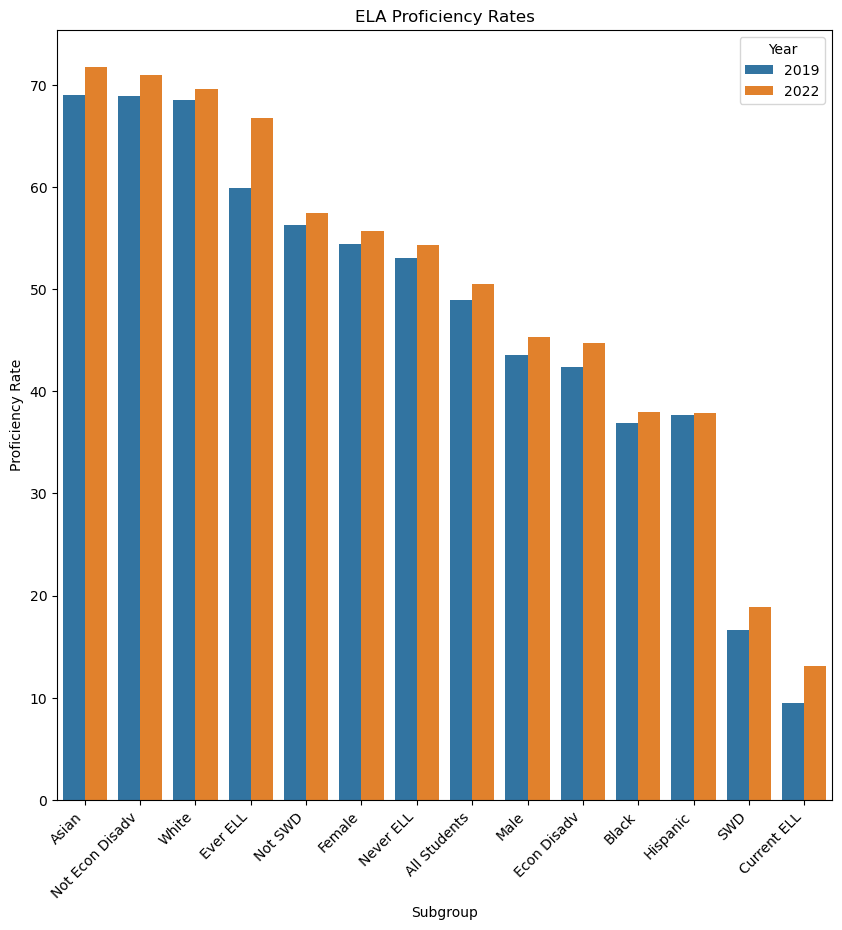

In [27]:
yoy_city = yoy_city.sort_values(by='prof_22_ela',ascending=False)


fig, ax1 = plt.subplots(figsize=(10, 10))
ela_plt = yoy_city[['Category','prof_19_ela','prof_22_ela']]
ela_plt.columns = ['Subgroup','2019','2022']
tidy = ela_plt.melt(id_vars='Subgroup').rename(columns=str.title)
tidy.columns=['Subgroup','Year','Proficiency Rate']
chart = sns.barplot(x='Subgroup', y='Proficiency Rate', hue='Year', data=tidy, ax=ax1)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('ELA Proficiency Rates')
plt.show()

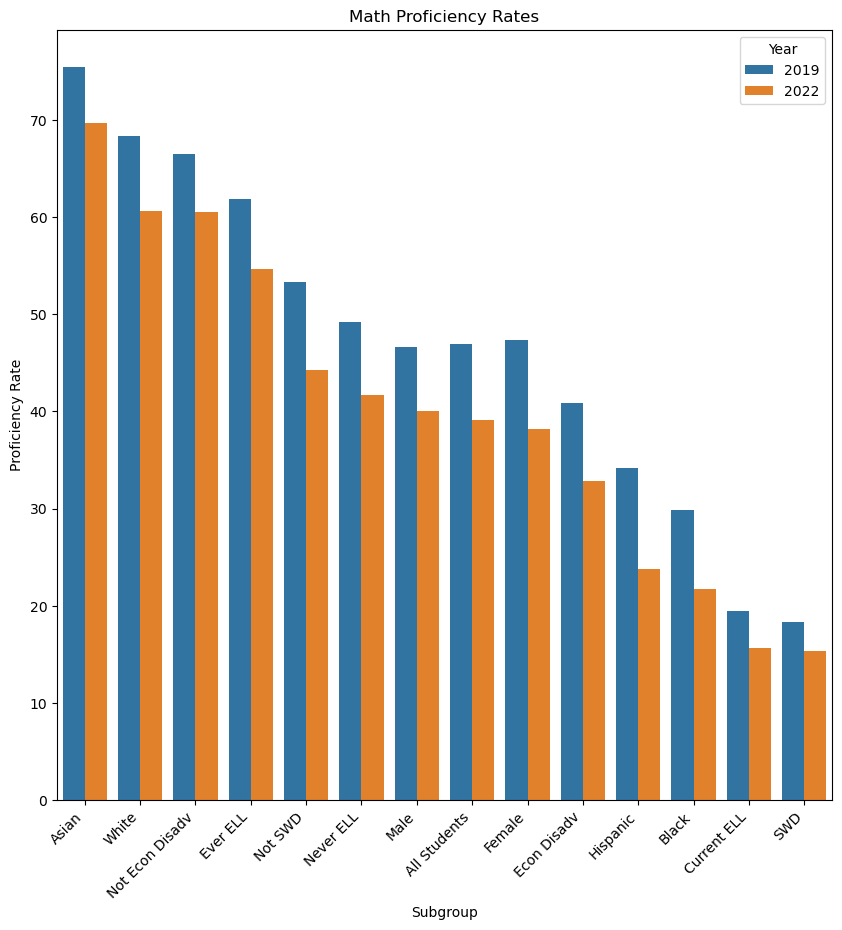

In [28]:
yoy_city = yoy_city.sort_values(by='prof_22_math',ascending=False)

fig, ax1 = plt.subplots(figsize=(10, 10))
math_plt = yoy_city[['Category','prof_19_math','prof_22_math']]
math_plt.columns = ['Subgroup','2019','2022']
tidy = math_plt.melt(id_vars='Subgroup').rename(columns=str.title)
tidy.columns=['Subgroup','Year','Proficiency Rate']
chart = sns.barplot(x='Subgroup', y='Proficiency Rate', hue='Year', data=tidy, ax=ax1)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title('Math Proficiency Rates')
plt.show()

Text(0.5, 1.0, 'Math Proficency by Race')

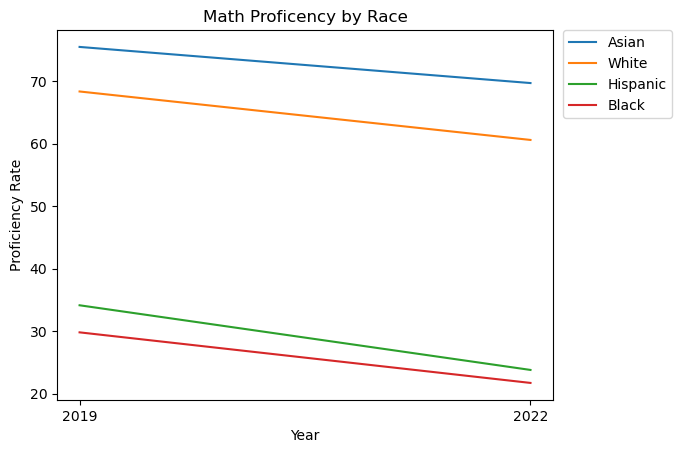

In [29]:
#achievement gap line chart
math_race = yoy_city[yoy_city['subgroup_type']=='race'][['Category','prof_19_math','prof_22_math']]
math_race.columns=['Subgroup','2019','2022']
math_race = math_race.melt(id_vars='Subgroup').rename(columns=str.title)
math_race.columns=['Subgroup','Year','Proficiency Rate']

fig, ax = plt.subplots()
sns.lineplot(x='Year', y='Proficiency Rate', hue='Subgroup', data=math_race)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Math Proficency by Race')


Text(0.5, 1.0, 'ELA Proficency by Race')

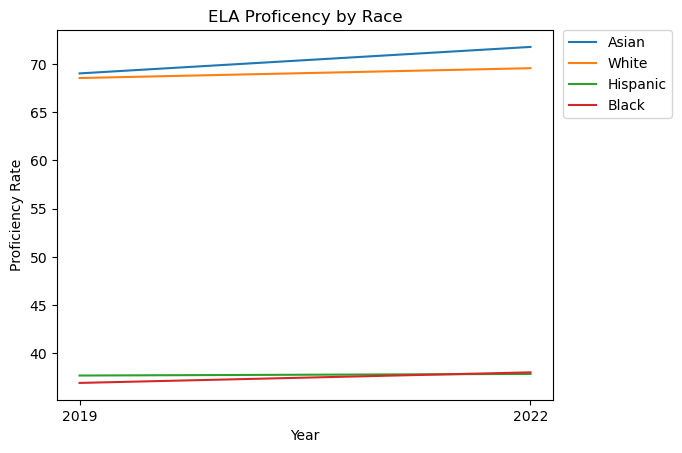

In [30]:
ela_race = yoy_city[yoy_city['subgroup_type']=='race'][['Category','prof_19_ela','prof_22_ela']]
ela_race.columns=['Subgroup','2019','2022']
ela_race = ela_race.melt(id_vars='Subgroup').rename(columns=str.title)
ela_race.columns=['Subgroup','Year','Proficiency Rate']

fig, ax = plt.subplots()
sns.lineplot(x='Year', y='Proficiency Rate', hue='Subgroup', data=ela_race)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('ELA Proficency by Race')

In [31]:


yoy_change = yoy_city[['subgroup_type','Category','ela_yoy','math_yoy']]
yoy_change.columns = ['Subgroup Type','Subgroup','Change in ELA','Change in Math']

yoy_change = yoy_change.sort_values(by='Subgroup Type',ascending=False)
yoy_change

,Subgroup Type,Subgroup,Change in ELA,Change in Math
11,swd,Not SWD,1.211408,-9.046656
12,swd,SWD,2.231035,-2.953093
1,race,Asian,2.746032,-5.782415
13,race,White,1.019800,-7.755706
7,race,Hispanic,0.166890,-10.347168
2,race,Black,1.095502,-8.092316
8,gender,Male,1.833197,-6.563411
6,gender,Female,1.312397,-9.162398
5,ell,Ever ELL,6.892834,-7.198012
9,ell,Never ELL,1.213658,-7.560064


In [32]:
test_dic = {
    'prof_19_ela':'ELA', 'prof_22_ela':'ELA', 'prof_19_math':'Math',
       'prof_22_math':'Math'}

year_dic = {
    'prof_19_ela':'2019', 'prof_22_ela':'2022', 'prof_19_math':'2019',
       'prof_22_math':'2022'}


In [33]:
yoy_city_all = yoy_city[yoy_city['subgroup_type']=='all'][[ 'prof_19_ela', 'prof_22_ela', 'prof_19_math',
       'prof_22_math']]
yoy_city_all = yoy_city_all.T.reset_index()
yoy_city_all.columns = ['key','Proficiency Rate']

yoy_city_all['Test'] = yoy_city_all['key'].map(test_dic)
yoy_city_all['Year'] = yoy_city_all['key'].map(year_dic)

yoy_city_all = yoy_city_all.pivot(index=['Test'], columns=['Year'], values=['Proficiency Rate'])
yoy_city_all[('Proficiency Rate','Change')] = yoy_city_all[('Proficiency Rate','2022')]- yoy_city_all[('Proficiency Rate','2019')]
yoy_city_all

Proficiency Rate                     
Year             2019       2022    Change
Test                                      
ELA         48.902426  50.486876  1.584450
Math        46.990714  39.155632 -7.835082

In [34]:
#generate summary table for grades
subgroup = ['all','swd','race','gender','econ_status','ell']

yoy_city_grade = YoY[YoY['Category']=='All Students'].groupby(by='Grade').sum()[['Ntested_19_ela',
       'Ntested_19_math', 'Ntested_22_ela', 'Ntested_22_math','Nprof_19_ela',
       'Nprof_19_math', 'Nprof_22_ela', 'Nprof_22_math']]

test_year = ['19_ela','22_ela','19_math','22_math']
for i in test_year:
    yoy_city_grade['prof_'+i] = (yoy_city_grade['Nprof_'+i]/yoy_city_grade['Ntested_'+i])*100


yoy_city_grade['ela_yoy'] = yoy_city_grade['prof_22_ela']- yoy_city_grade['prof_19_ela']
yoy_city_grade['math_yoy'] = yoy_city_grade['prof_22_math']- yoy_city_grade['prof_19_math']
yoy_city_grade = yoy_city_grade[['prof_19_ela', 'prof_22_ela','ela_yoy', 'prof_19_math','prof_22_math', 'math_yoy']]
yoy_city_grade.columns = ['ELA Proficiency Rate 2019','ELA Proficiency Rate 2022','ELA Proficiency Rate Change','Math Proficiency Rate 2019','Math Proficiency Rate 2022','Math Proficiency Rate Change']

yoy_city_grade

,ELA Proficiency Rate 2019,ELA Proficiency Rate 2022,ELA Proficiency Rate Change,Math Proficiency Rate 2019,Math Proficiency Rate 2022,Math Proficiency Rate Change
Grade,,,,,,
3,54.490740,50.314568,-4.176172,54.287639,49.369259,-4.918380
4,50.878094,44.768724,-6.109370,50.553928,42.964532,-7.589396
5,41.049198,40.160488,-0.888710,47.392097,38.709370,-8.682728
6,50.007929,58.137013,8.129085,45.444862,35.265367,-10.179495
7,44.444264,54.403205,9.958941,43.744873,37.336399,-6.408473
8,52.682951,55.118276,2.435325,37.828492,26.484991,-11.343501
All Grades,48.902426,50.486876,1.584450,46.990714,39.155632,-7.835082


In [35]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [36]:
districts

,school_dis,shape_area,shape_leng,geometry
0,32.0,5.189850e+07,37251.057496,"POLYGON ((-73.91181 40.70343, -73.91290 40.702..."
1,16.0,4.676362e+07,35848.904343,"POLYGON ((-73.93312 40.69579, -73.93237 40.695..."
2,17.0,1.284405e+08,68356.103241,"POLYGON ((-73.92044 40.66563, -73.92061 40.665..."
3,31.0,1.604167e+09,430023.147272,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
4,4.0,5.262057e+07,52062.883377,"MULTIPOLYGON (((-73.92134 40.80085, -73.92114 ..."
5,13.0,1.048711e+08,86649.098409,"POLYGON ((-73.97906 40.70595, -73.97924 40.705..."
6,15.0,1.961542e+08,153446.950332,"POLYGON ((-73.98633 40.69105, -73.98536 40.690..."
7,7.0,9.225887e+07,65300.619858,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
8,9.0,8.298071e+07,44396.450623,"MULTIPOLYGON (((-73.93309 40.82823, -73.93307 ..."
9,1.0,3.516047e+07,28647.015962,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."


In [37]:
YoY['school_dis'] = YoY['DBN'].str[:2].astype(float)


#Combine the district map file
map_yoy = YoY.merge(districts, on='school_dis')
map_yoy = map_yoy.rename(columns={"geometry": "district_geometry"})

#combine the school location file
map_yoy = map_yoy.merge(school_location, left_on='DBN',right_on='ATS System Code')
map_yoy = map_yoy.rename(columns={"geometry": "school_geometry"})
map_yoy

,DBN,School Name,Grade,Category,Ntested_19_ela,Ntested_19_math,Ntested_22_ela,Ntested_22_math,prof_19_ela,prof_19_math,...,district_geometry,ATS System Code,Primary Address,City,State Code,Zip,full_address,longitude,latitude,school_geometry
0,01M015,P.S. 015 ROBERTO CLEMENTE,3,All Students,27.0,26.0,21.0,21.0,70.370369,69.230766,...,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",01M015,333 EAST 4 STREET,MANHATTAN,NY,10009,"333 EAST 4 STREET, MANHATTAN, NY, 10009",-73.978737,40.721909,POINT (-73.97874 40.72191)
1,01M015,P.S. 015 ROBERTO CLEMENTE,3,Black,10.0,10.0,NaN,NaN,60.000000,60.000000,...,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",01M015,333 EAST 4 STREET,MANHATTAN,NY,10009,"333 EAST 4 STREET, MANHATTAN, NY, 10009",-73.978737,40.721909,POINT (-73.97874 40.72191)
2,01M015,P.S. 015 ROBERTO CLEMENTE,3,Econ Disadv,19.0,18.0,NaN,NaN,68.421051,61.111111,...,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",01M015,333 EAST 4 STREET,MANHATTAN,NY,10009,"333 EAST 4 STREET, MANHATTAN, NY, 10009",-73.978737,40.721909,POINT (-73.97874 40.72191)
3,01M015,P.S. 015 ROBERTO CLEMENTE,3,Female,12.0,12.0,12.0,12.0,75.000000,75.000000,...,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",01M015,333 EAST 4 STREET,MANHATTAN,NY,10009,"333 EAST 4 STREET, MANHATTAN, NY, 10009",-73.978737,40.721909,POINT (-73.97874 40.72191)
4,01M015,P.S. 015 ROBERTO CLEMENTE,3,Hispanic,11.0,10.0,12.0,12.0,63.636364,60.000000,...,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",01M015,333 EAST 4 STREET,MANHATTAN,NY,10009,"333 EAST 4 STREET, MANHATTAN, NY, 10009",-73.978737,40.721909,POINT (-73.97874 40.72191)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57777,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Male,158.0,164.0,130.0,93.0,23.417721,15.243902,...,"POLYGON ((-73.91181 40.70343, -73.91290 40.702...",32K562,125 COVERT STREET,BROOKLYN,NY,11207,"125 COVERT STREET, BROOKLYN, NY, 11207",-73.910355,40.68893,POINT (-73.91035 40.68893)
57778,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Never ELL,209.0,208.0,147.0,97.0,34.928230,21.153847,...,"POLYGON ((-73.91181 40.70343, -73.91290 40.702...",32K562,125 COVERT STREET,BROOKLYN,NY,11207,"125 COVERT STREET, BROOKLYN, NY, 11207",-73.910355,40.68893,POINT (-73.91035 40.68893)
57779,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Not Econ Disadv,17.0,19.0,18.0,17.0,23.529411,15.789474,...,"POLYGON ((-73.91181 40.70343, -73.91290 40.702...",32K562,125 COVERT STREET,BROOKLYN,NY,11207,"125 COVERT STREET, BROOKLYN, NY, 11207",-73.910355,40.68893,POINT (-73.91035 40.68893)
57780,32K562,EVERGREEN MIDDLE SCHOOL FOR URBAN EXPLORATION,All Grades,Not SWD,269.0,280.0,208.0,148.0,32.713753,22.142857,...,"POLYGON ((-73.91181 40.70343, -73.91290 40.702...",32K562,125 COVERT STREET,BROOKLYN,NY,11207,"125 COVERT STREET, BROOKLYN, NY, 11207",-73.910355,40.68893,POINT (-73.91035 40.68893)


In [38]:
#drop columns
map_yoy = map_yoy.drop(labels=[ 'shape_area', 'shape_leng','ATS System Code',
       'Primary Address', 'City', 'State Code', 'Zip', 'full_address',
       'longitude', 'latitude'], axis=1)

In [39]:
#pull out the borough, which is the 3rd character of the DBN
map_yoy['boro'] = map_yoy.DBN.str.slice(2,3)

#borough dictionary
boro_dict = {
    'K' : 'Brooklyn',
    'M' : 'Manhattan',
    'X' : 'Bronx', 
    'R' : 'Staten Island', 
    'Q' : 'Queens'
}

#map borough names to column
map_yoy['boro'] = map_yoy['boro'].map(boro_dict)

In [40]:
map_scores = map_yoy[map_yoy['Grade']=='All Grades'][['DBN', 'prof_22_ela','prof_22_math', 'school_geometry']]
map_scores = gpd.GeoDataFrame(map_scores, geometry='school_geometry')


Text(0.5, 0.98, 'SY22 ELA Proficiency Rates by School')

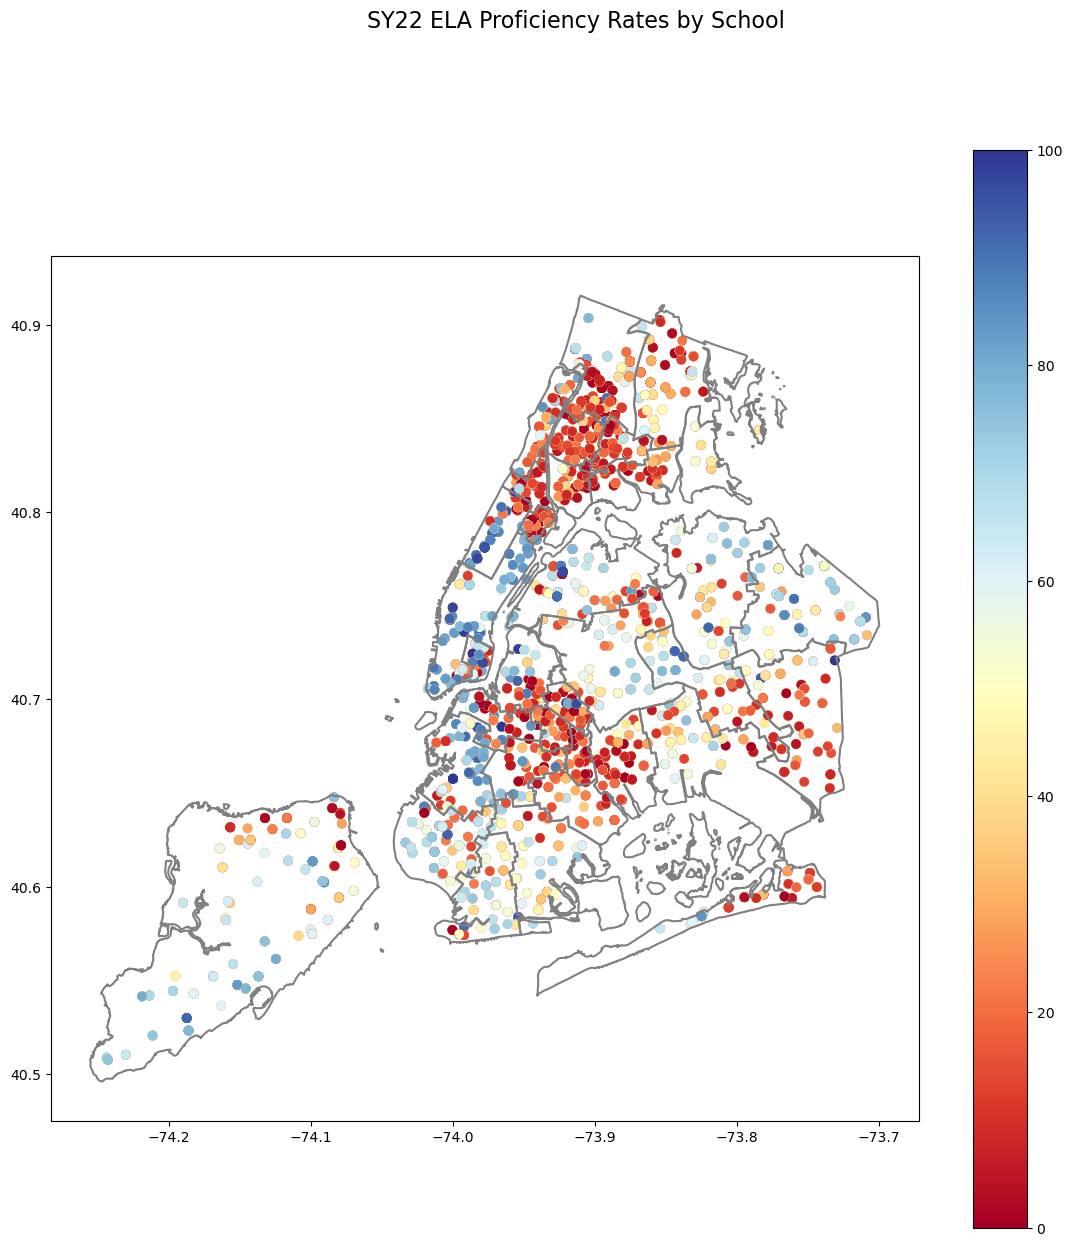

In [41]:
fig, ax = plt.subplots(1, figsize=(14,14))

map_scores.plot(ax=ax, column='prof_22_ela', k=10, legend=True, cmap='RdYlBu')
districts.boundary.plot(ax=ax, color='grey', markersize=5);
fig.suptitle('SY22 ELA Proficiency Rates by School', fontsize=16)


Text(0.5, 0.98, 'SY22 Math Proficiency Rates by School')

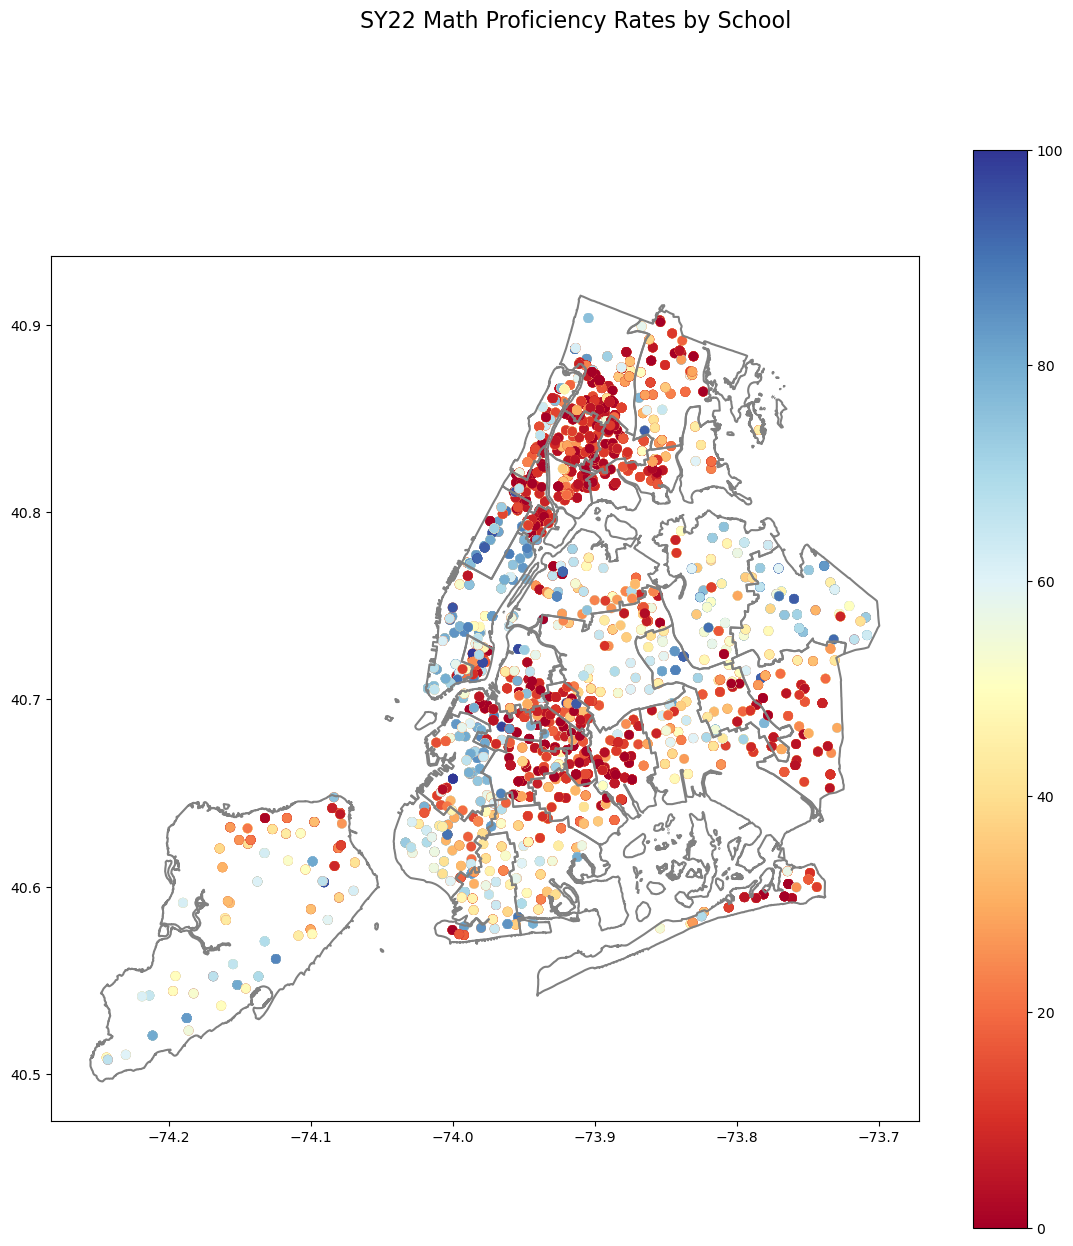

In [42]:
fig, ax = plt.subplots(1, figsize=(14,14))

map_scores.plot(ax=ax, column='prof_22_math', k=10, legend=True, cmap='RdYlBu')
districts.boundary.plot(ax=ax, color='grey', markersize=5);
fig.suptitle('SY22 Math Proficiency Rates by School', fontsize=16)


In [43]:
#map economic need 
demo['school_dis'] = demo['DBN'].str[:2].astype(float)

map_demo = demo.merge(school_location, left_on='DBN',right_on='ATS System Code')
map_demo = map_demo.rename(columns={"geometry": "school_geometry"})
map_demo = gpd.GeoDataFrame(map_demo, geometry='school_geometry')


Text(0.5, 0.98, 'SY22 Economic Need Index by School')

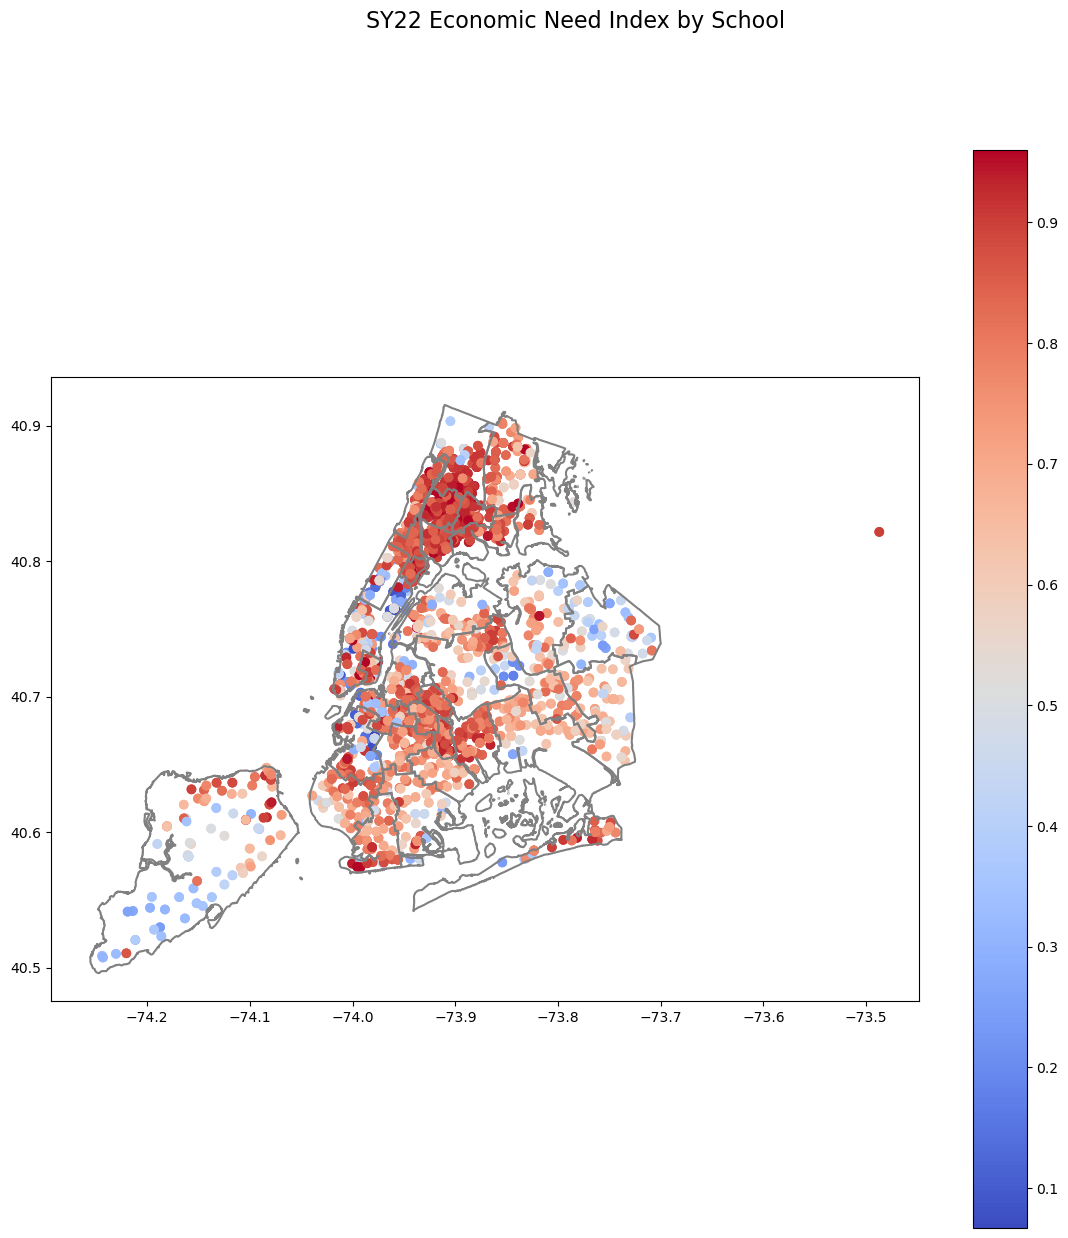

In [44]:
fig, ax = plt.subplots(1, figsize=(14,14))

map_demo.plot(ax=ax, column='Economic Need Index', k=10, legend=True, cmap='coolwarm')
districts.boundary.plot(ax=ax, color='grey', markersize=5);
fig.suptitle('SY22 Economic Need Index by School', fontsize=16)


In [45]:
#create a table for multivariate regression

sub_reg = YoY[(YoY['Grade']=='All Grades') & (YoY['Category'] != 'All Students')][['DBN','Category','Ntested_22_ela','Nprof_22_ela','Ntested_22_math', 'Nprof_22_math']]
sub_reg = sub_reg.pivot(index=['DBN'], columns=['Category'], values=['Ntested_22_ela','Nprof_22_ela','Ntested_22_math', 'Nprof_22_math'])
ela22_reg = sub_reg[('Ntested_22_ela')]
ela22_all =YoY[(YoY['Grade']=='All Grades') & (YoY['Category'] == 'All Students')][['DBN','prof_22_ela']]
ela22_reg = ela22_reg.merge(ela22_all, on='DBN')
ela22_reg = ela22_reg[['DBN', 'prof_22_ela', 'Asian', 'Black', 'Hispanic', 'White','Current ELL',  'Male', 'SWD']]
ela22_reg.columns = ['DBN', 'prof22ela', 'Asian', 'Black', 'Hispanic', 'White','CurrentELL', 'Male', 'SWD']

math22_reg = sub_reg[('Ntested_22_math')]
math22_all =YoY[(YoY['Grade']=='All Grades') & (YoY['Category'] == 'All Students')][['DBN','prof_22_math']]
math22_reg = math22_reg.merge(math22_all, on='DBN')
math22_reg = math22_reg[['DBN', 'prof_22_math', 'Asian', 'Black', 'Hispanic', 'White','Current ELL',  'Male', 'SWD']]
math22_reg.columns = ['DBN', 'prof22math', 'Asian', 'Black', 'Hispanic', 'White','CurrentELL',  'Male', 'SWD']
math22_reg

ela22_reg

,DBN,prof22ela,Asian,Black,Hispanic,White,CurrentELL,Male,SWD
0,01M015,31.081081,NaN,22.0,38.0,NaN,NaN,33.0,17.0
1,01M019,58.064518,NaN,11.0,39.0,NaN,NaN,28.0,11.0
2,01M020,23.636364,25.0,14.0,61.0,7.0,NaN,51.0,18.0
3,01M034,21.854305,NaN,64.0,76.0,NaN,10.0,86.0,51.0
4,01M063,32.352940,NaN,7.0,22.0,NaN,NaN,18.0,8.0
...,...,...,...,...,...,...,...,...,...
1117,32K377,15.686275,NaN,NaN,41.0,NaN,15.0,22.0,13.0
1118,32K383,59.424084,25.0,206.0,509.0,15.0,59.0,353.0,95.0
1119,32K384,30.612246,NaN,22.0,171.0,NaN,50.0,95.0,38.0
1120,32K554,88.535034,10.0,19.0,99.0,27.0,NaN,75.0,9.0


In [46]:
lm = smf.ols(formula = 'prof22ela ~ '+ '+'.join(ela22_reg.columns[2:]), data = ela22_reg).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              prof22ela   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     38.31
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.68e-39
Time:                        22:21:42   Log-Likelihood:                -1389.4
No. Observations:                 349   AIC:                             2795.
Df Residuals:                     341   BIC:                             2826.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.4155      1.318     37.486      0.0

In [47]:
lm = smf.ols(formula = 'prof22math ~ '+ '+'.join(ela22_reg.columns[2:]), data =math22_reg).fit()
OLS_coef=lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             prof22math   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     43.96
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.20e-43
Time:                        22:21:42   Log-Likelihood:                -1379.0
No. Observations:                 337   AIC:                             2774.
Df Residuals:                     329   BIC:                             2805.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.2720      1.591     30.341      0.0